# Appendix A: Lie Group Integrators

In any implementation of time-varying systems, thought must be given to numerical integration methods for finding approximate solutions to differential equations. Typical algorithms include Euler's Method and Runge-Kutta Methods (i.e., RK4). However, these classical algorithms are developed for use on flat Euclidean spaces and numerical instability issues can arise when applied to curvy manifolds such as the Lie groups relevant to robotics.

Consider the following motivating example in $S^1$


In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

class S1:
    def __init__(self, theta=0):
        # The representation of the group element
        self.g = self.from_algebra(theta)
        
        # Also store the original element of the algebra
        self.theta = theta
    
    def from_algebra(self, theta):
        return np.exp(1j*theta)
    
    def to_algebra(self, g):
        return np.imag(np.log(g))
    
    def as_matrix(self):
        return self.R
    
    def as_vector(self):
        return self.R[:,0]
    
    def as_complex(self):
        return self.mat[0,0] + self.mat[1,0]*1j
    
    def visualize(self, trajectory=np.array([])):
        """Visualize the group element on its manifold
        :param trajectory: optional list of group elements to plot
        """
        fig = plt.figure(figsize=(7,7))

        n = np.linspace(0, 2*np.pi, 100)
        plt.plot(np.cos(n), np.sin(n))
        plt.axis('square'), plt.axis([-2, 2, -2, 2]), plt.axis('off')
        # frame1 = plt.gca()
        # frame1.axes.get_xaxis().set_visible(False)
        # frame1.axes.get_yaxis().set_visible(False)
        
        if not trajectory.size:
            trajectory = np.array([self.g])

        x, y = np.real(trajectory), np.imag(trajectory)
        plt.scatter(x, y, s=50, c='r')
        
        plt.show()

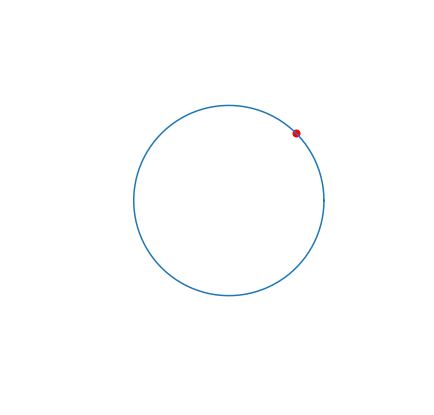

In [2]:
z = S1(theta=np.pi/4)
z.visualize()

In [3]:
class S1(S1):
    def euler_integration(self, w, Ts, secs=0):
        # convert seconds to steps
        steps = int(secs/Ts)
        
        # Store trajectory
        trajectory = np.zeros((steps+1,), dtype=complex)
        trajectory[0] = self.g
        
        f = lambda g: 1j*w*g
        
        for i in range(steps):
            self.g += Ts*f(self.g)
            trajectory[i+1] = self.g
            
        return trajectory

|z_final| = 1.0253


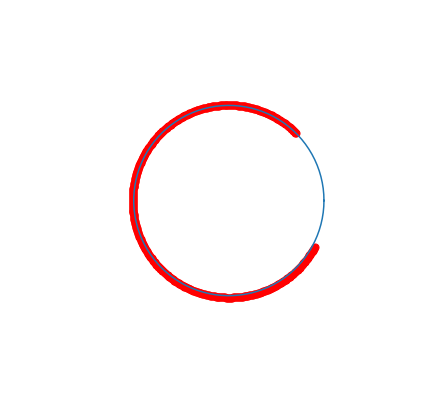

In [30]:
z = S1(theta=np.pi/4)
traj = z.euler_integration(1, 0.01, secs=5)
print("|z_final| = {:.4f}".format(np.abs(traj[-1])))
z.visualize(traj)

In [7]:
class S1(S1):
    def rk4_integration(self, w, Ts, secs=0):
        # convert seconds to steps
        steps = int(secs/Ts)
        
        # Store trajectory
        trajectory = np.zeros((steps+1,), dtype=complex)
        trajectory[0] = self.g
        
        f = lambda t, g: 1j*w*g
        
        for i in range(steps):
            t = i*Ts
            k1 = f(t, self.g)
            k2 = f(t + Ts/2, self.g + Ts/2*k1)
            k3 = f(t + Ts/2, self.g + Ts/2*k2)
            k4 = f(t + Ts  , self.g + Ts  *k3)
            self.g += (Ts/6)*(k1 + 2*k2 + 2*k3 + k4)
            trajectory[i+1] = self.g
            
        return trajectory

|z_final| = 0.5322


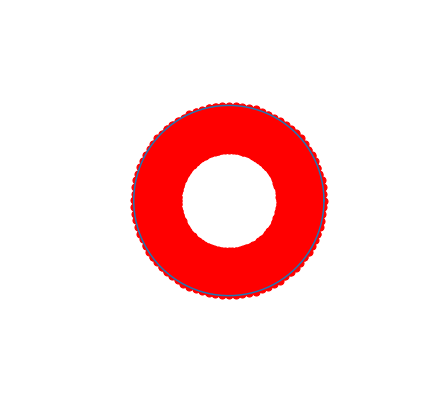

In [39]:
z = S1(theta=np.pi/4)
traj = z.rk4_integration(50, 0.01, secs=60)
print("|z_final| = {:.4f}".format(np.abs(traj[-1])))
z.visualize(traj)

In [ ]:
class S1(S1):
    def lie_integration(self, w, Ts, secs=0):
        # convert seconds to steps
        steps = int(secs/Ts)
        
        # Store trajectory
        trajectory = np.zeros((steps+1,), dtype=complex)
        trajectory[0] = self.g
        
        f = lambda t, g: 1j*w*g
        
        for i in range(steps):
            t = i*Ts
            k1 = f(t, self.g)
            k2 = f(t + Ts/2, self.g + Ts/2*k1)
            k3 = f(t + Ts/2, self.g + Ts/2*k2)
            k4 = f(t + Ts  , self.g + Ts  *k3)
            self.g += (Ts/6)*(k1 + 2*k2 + 2*k3 + k4)
            trajectory[i+1] = self.g
            
        return trajectory